# An Exploration of State-Level Wiretapping in California

In [2]:
# Make code toggle-able for easier review.
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<i>The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a></i>.''')

## Introduction

In [20]:
# Import the necessary libraries.
import statistics
import numpy as np
import pandas as pd
from scipy.stats import mstats
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
% matplotlib inline
import seaborn as sns

In [4]:
# Import the raw wiretapping data (sourced from https://www.kaggle.com/eff/california-wire-tapping)
# Information here: https://www.eff.org/deeplinks/2017/06/california-finally-releases-wiretap-dataset
# State report here: https://www.eff.org/files/2017/06/09/2016_ca_electronic_interceptions_report.pdf
wt_data = pd.read_csv('/Users/guest/Desktop/Capstone/california_wt2_export_2016.csv')

# Add a column for total cost.
wt_data['TotalCost'] = wt_data['PersonnelCost'] + wt_data['ResourceCost']

# Replace nans with 0s in the arrested and incriminating interception columns where appropriate.
wt_data['Arrested'] = np.nan_to_num(wt_data['Arrested'])
wt_data['Incriminating'] = np.nan_to_num(wt_data['Incriminating'])

# Add a binary column for arrests.
wt_data['Arrested_Binary'] = wt_data['Arrested'] > 0
wt_data['Arrested_Binary'] = wt_data['Arrested_Binary'] * 1

# Add a binary column for interception of incriminating materials.
wt_data['Incriminating_Binary'] = wt_data['Incriminating'] > 0
wt_data['Incriminating_Binary'] = wt_data['Incriminating_Binary'] * 1

# Add a column that codes cost ordinally

cost_recode = []

for row in wt_data['TotalCost']:
    if row > 0 and row <= 50000:
        cost_recode.append(1)
    elif row > 50000 and row <= 100000:
        cost_recode.append(2)
    elif row > 100000 and row <= 150000:
        cost_recode.append(3)
    elif row > 150000 and row <= 200000:
        cost_recode.append(4)
    elif row > 200000:
        cost_recode.append(5)
    elif row == 0:
        cost_recode.append(0)

wt_data['Cost_Recode'] = cost_recode

In [5]:
# Import county population data (sourced from http://www.dof.ca.gov/Forecasting/Demographics/Estimates/E-1/)
county_pop = pd.read_csv('/Users/guest/Desktop/Capstone/CA_county_population.csv', index_col=0)

In [6]:
# Marker styles and colors for later use.
markers = ['.', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
colors = ['#e6194b', '#3cb44b', '#ffe119', '#0082c8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#d2f53c', '#fabebe', '#008080', '#e6beff', '#aa6e28', '#800000', '#aaffc3', '#808000', '#000080']

In [7]:
# Calculate correlation coefficients. 
cost_arrest_r = round(mstats.pearsonr(wt_data['TotalCost'], wt_data['Arrested'])[0],3) # overall cost / arrests
cost_incriminating_r = round(mstats.pearsonr(wt_data['TotalCost'], wt_data['Incriminating'])[0],3) # overall cost / incriminating interceptions
incriminating_arrest_r= round(mstats.pearsonr(wt_data['Incriminating_Binary'], wt_data['Arrested_Binary'])[0],3) # presence or absence of incriminating messages / presence or absence of arrest
incriminating_arrest_p= round(float(mstats.pearsonr(wt_data['Incriminating_Binary'], wt_data['Arrested_Binary'])[1]),4) # presence or absence of incriminating messages / presence or absence of arrest

In [8]:
# Calculate the trend line for the relationship between expenditures and arrests.
arrest_z = np.polyfit(wt_data['TotalCost'], wt_data['Arrested'], 1)
arrest_p = np.poly1d(arrest_z)

# Calculate the trend line for the relationship between incriminating interceptions and arrests.
incriminating_z = np.polyfit(wt_data['TotalCost'], wt_data['Incriminating'], 1)
incriminating_p = np.poly1d(incriminating_z)

In [9]:
# JURISDICTION DATAFRAME

all_jurisdictions = wt_data['Jurisdiction'].unique()

# Store overall data in lists for later conversion to dataframe.
jurisdiction = ['Overall'] # Jurisdiction names
pop = [] # Populations of each jurisdiction
jur_freqs = [wt_data.shape[0]] # Number of cases
jur_persons = [wt_data['Persons'].sum()] # Number of people tapped
jur_costs = [wt_data['TotalCost'].sum()] # Expenditures
arrest_corr = [cost_arrest_r] # Correlation coefficient (cost & arrests)
incriminating_corr = [cost_incriminating_r] # Correlation coefficient (cost & incriminating intercepts)
dummy_zero = [0] # To allow for one-dimensional plotting of correlation coefficients
label_shape = ['o'] # To allow for consistent labeling throughout plots.
label_color = ['black'] # To allow for consistent labeling throughout plots.

# Calculate and store jurisdiction-specific data
label_count = 0

for county in all_jurisdictions: 
    
    # Select the jurisdiction's cases only.
    county_corr_slice = wt_data.loc[lambda df: wt_data['Jurisdiction'] == county, :]    
    
    # Log jurisdiction, valid n, and dummy zero.
    jurisdiction.append(county)
    pop.append(county_pop.get_value(county,'01_16_population'))
    jur_freqs.append(county_corr_slice.shape[0])
    dummy_zero.append(0)
    
    # Log the sum of wiretapping costs
    sum_slice = wt_data.loc[lambda df: wt_data['Jurisdiction'] == county, :]
    jur_costs.append(sum_slice['TotalCost'].sum())
    jur_persons.append(sum_slice['Persons'].sum())
    
    # Assign color and marker styles to the jurisdiction.
    label_shape.append(markers[label_count])
    label_color.append(colors[label_count])
    label_count = label_count + 1
    
    # Log correlations or, if appropriate, blanks.
    if county_corr_slice.shape[0] <= 50:
        arrest_corr.append(np.nan)
        incriminating_corr.append(np.nan)
    else:
        arrest_corr.append(mstats.pearsonr(county_corr_slice['TotalCost'], county_corr_slice['Arrested'])[0])
        incriminating_corr.append(mstats.pearsonr(county_corr_slice['TotalCost'], county_corr_slice['Incriminating'])[0])

# Add population to the 'Overall' column
pop_total = sum(pop)
pop.insert(0, pop_total)        


jur_perc_str = []
for freq in jur_freqs:
    freq_per = str(round(100 * (freq / wt_data.shape[0]),1)) + '%'
    jur_perc_str.append(freq_per)

# Store the jurisdiction data in a dataframe.      
jurisdiction_data = pd.DataFrame()
jurisdiction_data['jurisdiction'] = jurisdiction
jurisdiction_data = jurisdiction_data.set_index(['jurisdiction'])

jurisdiction_data['jur_id'] = range(len(jurisdiction_data))
jurisdiction_data['pop'] = pop
jurisdiction_data['valid_n'] = jur_freqs
jurisdiction_data['freq_per_cap'] = jurisdiction_data['valid_n']/jurisdiction_data['pop']
jurisdiction_data['persons'] = jur_persons

# Remove the outlier
jurisdiction_data.loc['Riverside','persons'] = jurisdiction_data.loc['Riverside','persons'] - 91116

jurisdiction_data['persons_per_cap'] = jurisdiction_data['persons']/jurisdiction_data['pop']
jurisdiction_data['cost'] = jur_costs
jurisdiction_data['cost_per_cap'] = jurisdiction_data['cost']/jurisdiction_data['pop']
jurisdiction_data['arrest_corr'] = arrest_corr
jurisdiction_data['incriminating_corr'] = incriminating_corr
jurisdiction_data['dummy_zero'] = dummy_zero
jurisdiction_data['perc'] = (jurisdiction_data['valid_n'] / wt_data.shape[0])
jurisdiction_data['perc_str'] = jur_perc_str
jurisdiction_data['shape'] = label_shape
jurisdiction_data['color'] = label_color

In [10]:
# JUDGE DATA DATAFRAME

jurisdiction_indexes = {}

for jurisdiction in wt_data['Jurisdiction'].unique():
    all_jurisdictions = list(wt_data['Jurisdiction'].unique())
    jurisdiction_indexes[jurisdiction] = all_jurisdictions.index(jurisdiction)

sum_total = 0

judges = []
judge_costs = []
jurisdiction_list = []
jurisdiction_pop = []
y_position = []
numeric_judge =[]
cases = []
judge_color = []

for judge_var in wt_data['Judge'].unique():
    judge_plot_slice = wt_data.loc[lambda df: wt_data['Judge'] == judge_var, :]
    for county in judge_plot_slice['Jurisdiction'].unique():
        n_cases = judge_plot_slice.loc[lambda df: judge_plot_slice['Jurisdiction'] == county, :].shape[0]
        judges.append(judge_var)
        jurisdiction_pop.append(jurisdiction_data.get_value(county,'pop'))
        jurisdiction_list.append(county)
        cases.append(n_cases)
        judge_costs.append(judge_plot_slice['TotalCost'].sum())
        y_position.append(jurisdiction_indexes.get(county))
        judge_color.append(jurisdiction_data.get_value(county,'color'))
        
judge_data = pd.DataFrame()
judge_data['judge'] = judges
judge_data['jur_pop'] = jurisdiction_pop
judge_data['jurisdiction'] = jurisdiction_list
judge_data['n_cases'] = cases
judge_data['cost'] = judge_costs
judge_data['cost_per_cap'] = judge_data['cost']/judge_data['jur_pop']
judge_data['y_pos'] = y_position
judge_data['color'] = judge_color

In [11]:
# COMMUNICATION METHOD DATAFRAME

# The intercept locations are split across several columns; consolidate them.
intercept_variables = ('InterceptOne', 'InterceptTwo', 'InterceptThree', 'InterceptFour')
intercept_types = []
intercept_freqs = []

# Create a list of unique intercept types.
for var in intercept_variables:
    intercept_types.extend(wt_data[var])
intercept_types = list([x for x in list(set(intercept_types)) if str(x) != 'nan'])

# Define "other" variable and sum across all columns.
other_freq = 0
other_types = []

for int_type in intercept_types:
    in1 = wt_data.loc[lambda df: wt_data['InterceptOne'] == int_type, :].shape[0]
    in2 = wt_data.loc[lambda df: wt_data['InterceptTwo'] == int_type, :].shape[0]
    in3 = wt_data.loc[lambda df: wt_data['InterceptThree'] == int_type, :].shape[0]
    in4 = wt_data.loc[lambda df: wt_data['InterceptFour'] == int_type, :].shape[0]
    total = in1 + in2 + in3 + in4
    
    if total < 50:
        other_freq = other_freq + total
        other_types.append(int_type)
    
    else:
        intercept_freqs.append(total)


intercept_types = list([x for x in list(set(intercept_types)) if str(x) not in other_types])

intercept_types.append('Other Mode of Communication*')
intercept_freqs.append(other_freq)

int_perc_str = []
for freq in intercept_freqs:
    freq_per = str(round(100 * (freq / wt_data.shape[0]),1)) + '%'
    int_perc_str.append(freq_per)

# Consolidate these lists into a dataframe.
intercept_data = pd.DataFrame()
intercept_data['int_type'] = intercept_types
intercept_data['int_id'] = np.arange(len(intercept_freqs))
intercept_data['int_freq'] = intercept_freqs
intercept_data['perc'] = (intercept_data['int_freq'] / wt_data.shape[0])
intercept_data['perc_str'] = int_perc_str
intercept_data['label'] = intercept_data['int_type'] + ' (' + intercept_data['perc_str'] + ')'
intercept_data = intercept_data.set_index(intercept_data['int_type'])


## Question 1: What types of wiretapping were approved at the state level?
* Crime (bar chart) √
* Number of people surveilled (box chart) √
* Type of communication intercepted (bar chart) √
* Duration of tap (histogram) √

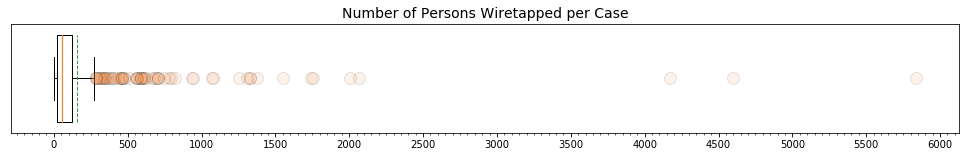

In [12]:
# Number of People Surveilled

cleaned_bplot = wt_data.copy().drop([379, 223, 263, 313, 484, 496])

plt.figure(figsize=(17,2))

medianprops = dict(linestyle='-', linewidth=1.2, color='#f58231')
flierprops = dict(marker='o', markerfacecolor='#f58231', markersize=12, linestyle='none', alpha=.1)

plt.boxplot(cleaned_bplot['Persons'],
            showmeans=True,
            meanline=True,
            vert=False,
            widths=.8,
            flierprops=flierprops,
            medianprops=medianprops)

plt.title('Number of Persons Wiretapped per Case', fontsize=14)

ax = plt.axes()

ax.xaxis.set_major_locator(ticker.MultipleLocator(500))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(50))

ax.yaxis.set_ticks([])

plt.show()

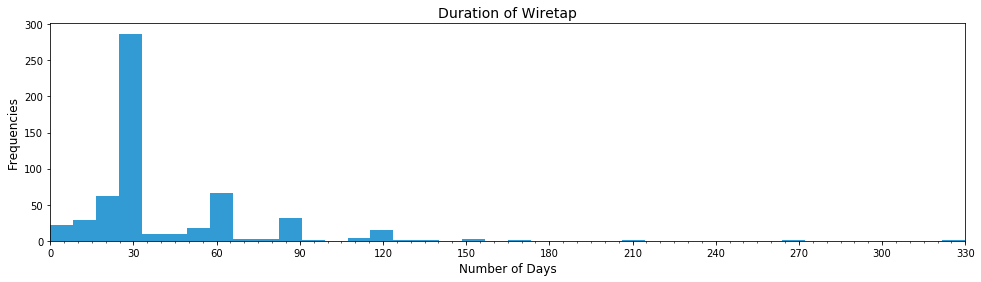

In [13]:
# Duration of Surveillance

cleaned_hist = wt_data.loc[lambda df: pd.isnull(wt_data['TotalDaysUsed']) == False, :]


plt.figure(figsize=(16.4,4))

plt.hist(cleaned_hist['TotalDaysUsed'], color='#0082c8', bins=40, alpha=0.8)

plt.title('Duration of Wiretap', fontsize=14)

ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.set_xlim(min(cleaned_hist['TotalDaysUsed']), max(cleaned_hist['TotalDaysUsed']))

ax.set_ylabel('Frequencies', fontsize=12)
ax.set_xlabel('Number of Days', fontsize=12)



plt.show()

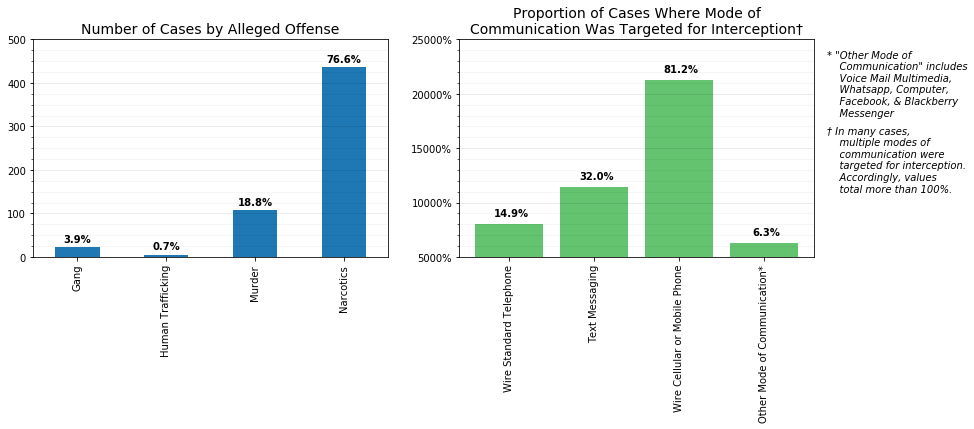

In [14]:
# Mode of Communication Intercepted

fig = plt.figure(figsize=(14,4))


# Crime
ax1 = fig.add_subplot(1,2,1)
wt_data.groupby('Offense').size().plot(kind='bar')

ax1.set_title('Number of Cases by Alleged Offense', fontsize=14)
ax1.set_xlabel('', fontsize=12)


crime_x_coord = {'Gang': 0, 'Human Trafficking':1, 'Murder':2, 'Narcotics':3}
for crime in wt_data['Offense'].unique():
    x = crime_x_coord[crime]
    y = wt_data.loc[lambda df: wt_data['Offense'] == crime, :].shape[0]
    label = str(round(y/wt_data.shape[0]*100,1)) + '%'
    plt.text(x,y+20,label,weight='semibold', va='center', ha='center')
    

ax1.grid(b=None, which='both', axis='y', color='black', alpha=0.05, zorder=0)

ax1.yaxis.set_minor_locator(ticker.MultipleLocator(25))
ax1.set_ylim(0, 500)


# Intercept Type
ax2 = fig.add_subplot(1,2,2)
plt.bar(intercept_data['int_id'], intercept_data['perc'], alpha= 0.8, color='#3cb44b')

ax2.set_title('Proportion of Cases Where Mode of\nCommunication Was Targeted for Interception†', fontsize=14)

for var in intercept_data['int_type']:
    x = intercept_data.get_value(var,'int_id')
    y = intercept_data.get_value(var,'perc')
    label = intercept_data.get_value(var,'perc_str')
    plt.text(x+.025,y+.05,label,weight='semibold', va='center', ha='center')

ax2.grid(b=None, which='both', axis='y', color='black', alpha=0.05, zorder=0)

int_labels = ['']
for mode in intercept_data['int_type']:
    int_labels.append(mode)
ax2.set_xticklabels(labels=int_labels, rotation=90)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax2.set_yticklabels(['{:3.0f}%'.format(int(x*100)) for x in ax.get_yticks()])
ax2.set_ylim(0,1)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(.25))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(.05))

footnote1 = '* "Other Mode of\n    Communication" includes\n    Voice Mail Multimedia,\n    Whatsapp, Computer,\n    Facebook, & Blackberry\n    Messenger'
footnote2 = '† In many cases,\n    multiple modes of\n    communication were\n    targeted for interception.\n    Accordingly, values\n    total more than 100%.'
ax2.text(3.74,.65,footnote1, fontsize=10, style='italic')
ax2.text(3.74,.30,footnote2, fontsize=10, style='italic')


plt.show()

## Question 2: How do wiretapping approvals and expenditures vary by jurisdiction?
* Cases by jurisdiction (bar chart) √
* Rates by jurisdiction (bar chart) √
* Cost by jurisdiction and judge (bar chart) √

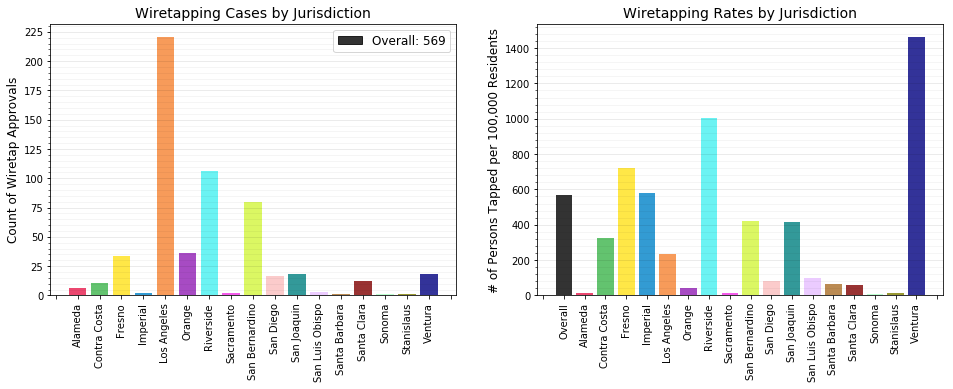

In [15]:
tick_labels = ['','']
for county in jurisdiction_data.index:
    tick_labels.append(county)

tick_labels2 = ['','']
for county in jurisdiction_data.index[1:]:
    tick_labels2.append(county)

fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(1,2,1)
plt.bar(jurisdiction_data['jur_id'][1:],
        jurisdiction_data['valid_n'][1:],
        color=jurisdiction_data['color'][1:],
        alpha=0.8)

ax1.set_title('Wiretapping Cases by Jurisdiction', fontsize=14)
ax1.set_ylabel('Count of Wiretap Approvals', fontsize=12)
ax1.grid(b=None, which='both', axis='y', color='black', alpha=0.05, zorder=0)

ax1.set_xticklabels(labels=tick_labels2, rotation=90)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(25))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(5))
total_count = mpatch.Patch(color='black',
                           label='Overall: ' + str(jurisdiction_data.get_value('Overall','valid_n')),
                           
                           alpha=0.8)
ax1.legend(handles=[total_count], prop={'size': 12})



#jur_no_outliers = jurisdiction_data.df.drop(['Cochice', 'Pima']).copy()


ax2 = fig.add_subplot(1,2,2)
ax2.bar(jurisdiction_data['jur_id'],
        jurisdiction_data['persons_per_cap']*100000,
        color=jurisdiction_data['color'],
        alpha=0.8)
ax2.set_title('Wiretapping Rates by Jurisdiction', fontsize=14)
ax2.set_ylabel('# of Persons Tapped per 100,000 Residents', fontsize=12)
ax2.grid(b=None, which='both', axis='y', color='black', alpha=0.05, zorder=0)

ax2.set_xticklabels(labels=tick_labels, rotation=90)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax2.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(40))

plt.show()

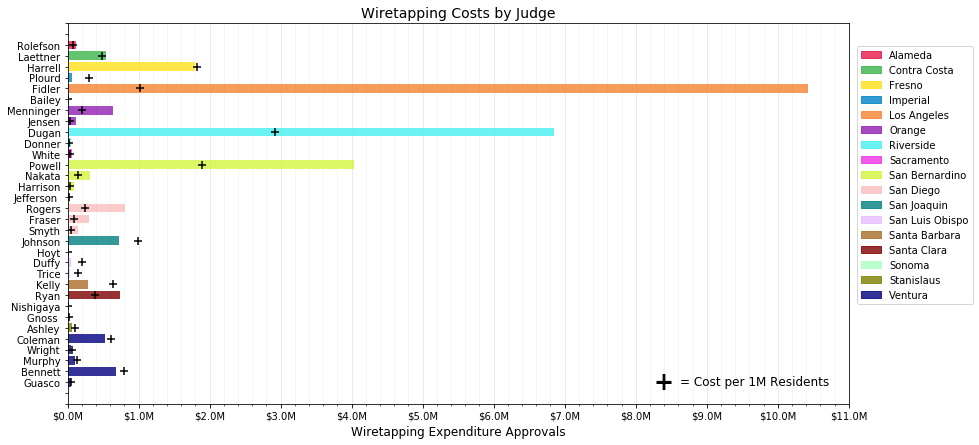

In [16]:
# Cost by Location and Judge

plt.figure(figsize=(14,7))

plt.scatter(judge_data['cost_per_cap']*1000000, judge_data.index[::-1], color='black', marker='+', s=80, zorder=3)
plt.barh(judge_data.index[::-1], judge_data['cost'], color=judge_data['color'], alpha=0.8, zorder=2)

# Axis Labels
plt.title('Wiretapping Costs by Judge', fontsize=14)
plt.xlabel('Wiretapping Expenditure Approvals', fontsize=12)


# Format Ticks
tick_labels = ['','']
for judge in judge_data['judge'][::-1]:
    tick_labels.append(judge)

def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (x*1e-6)

formatter = ticker.FuncFormatter(millions)

ax = plt.axes()
ax.grid(b=None, which='both', axis='x', color='black', alpha=0.05, zorder=0)
ax.set_xlim(0,11000000)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000000))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(200000))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_yticklabels(labels=tick_labels)

# Format Index
judge_location_patches = {}

for jurisdiction in all_jurisdictions:
    key = jurisdiction.replace(' ','_').lower() + '_judge_label'
    value = jurisdiction
    judge_location_patches[key] = value

    
alameda_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('Alameda','color'),
                             label=judge_location_patches['alameda_judge_label'],alpha=0.8)
contra_costa_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('Contra Costa','color'),
                             label=judge_location_patches['contra_costa_judge_label'],alpha=0.8)
fresno_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('Fresno','color'),
                             label=judge_location_patches['fresno_judge_label'],alpha=0.8)
imperial_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('Imperial','color'),
                             label=judge_location_patches['imperial_judge_label'],alpha=0.8)
los_angeles_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('Los Angeles','color'),
                             label=judge_location_patches['los_angeles_judge_label'],alpha=0.8)
orange_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('Orange','color'),
                             label=judge_location_patches['orange_judge_label'],alpha=0.8)
riverside_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('Riverside','color'),
                             label=judge_location_patches['riverside_judge_label'],alpha=0.8)
sacramento_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('Sacramento','color'),
                             label=judge_location_patches['sacramento_judge_label'],alpha=0.8)
san_bernardino_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('San Bernardino','color'),
                             label=judge_location_patches['san_bernardino_judge_label'],alpha=0.8)
san_diego_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('San Diego','color'),
                             label=judge_location_patches['san_diego_judge_label'],alpha=0.8)
san_joaquin_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('San Joaquin','color'),
                             label=judge_location_patches['san_joaquin_judge_label'],alpha=0.8)
san_luis_obispo_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('San Luis Obispo','color'),
                             label=judge_location_patches['san_luis_obispo_judge_label'],alpha=0.8)
santa_barbara_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('Santa Barbara','color'),
                             label=judge_location_patches['santa_barbara_judge_label'],alpha=0.8)
santa_clara_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('Santa Clara','color'),
                             label=judge_location_patches['santa_clara_judge_label'],alpha=0.8)
sonoma_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('Sonoma','color'),
                             label=judge_location_patches['sonoma_judge_label'],alpha=0.8)
stanislaus_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('Stanislaus','color'),
                             label=judge_location_patches['stanislaus_judge_label'],alpha=0.8)
ventura_judge_label = mpatch.Patch(color=jurisdiction_data.get_value('Ventura','color'),
                             label=judge_location_patches['ventura_judge_label'],alpha=0.8)

plt.legend(handles=[alameda_judge_label, contra_costa_judge_label, fresno_judge_label, imperial_judge_label, 
                     los_angeles_judge_label, orange_judge_label, riverside_judge_label, sacramento_judge_label, 
                     san_bernardino_judge_label, san_diego_judge_label, san_joaquin_judge_label, 
                     san_luis_obispo_judge_label, santa_barbara_judge_label, santa_clara_judge_label, 
                     sonoma_judge_label, stanislaus_judge_label, ventura_judge_label],
                     loc='center right',
                    bbox_to_anchor=(1.165, .6))

plt.text(8250000,.02,'+', fontsize=24, weight='bold', va='center')
plt.text(8630000,.02,'= Cost per 1M Residents', fontsize=12, va='center')
plt.show()

## Question 3: How do wiretapping expenditures relate to law enforcement outcomes?
* Arrests by cost (scatter plot) √
* Incriminating intercepts by cost (scatter plot) √
* Cost and Arrests by crime (heat map) 
* Correlation between interception and arrest (scatter plot) √
* Surveilled leading to arrest vs. surveilled leading to no arrests (bar chart)

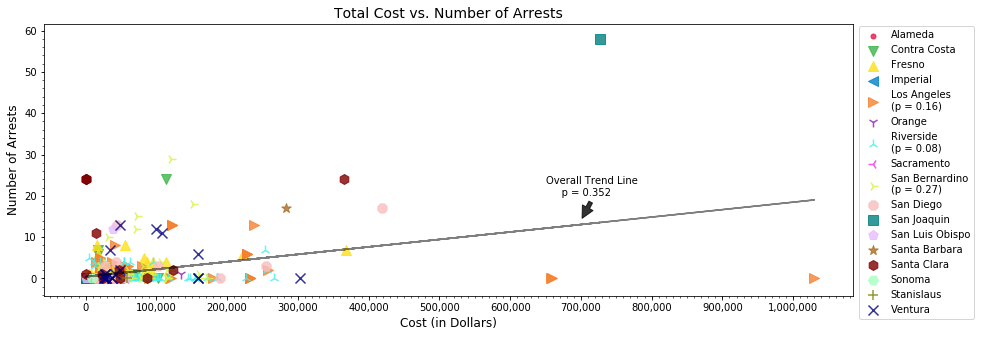

In [17]:
# Plot the arrest correlation chart
plt.figure(figsize=(14.5,5))

for jurisdiction in all_jurisdictions:
    
    jurisdiction_plot_slice = wt_data.loc[lambda df: wt_data['Jurisdiction'] == jurisdiction, :]
    
    if pd.notnull(jurisdiction_data.get_value(jurisdiction,'arrest_corr')) == True:
        setlabel = jurisdiction + '\n(p = ' + str(round(jurisdiction_data.get_value(jurisdiction,'arrest_corr'),2)) + ')'
    else:
        setlabel = jurisdiction
    
    plt.scatter(jurisdiction_plot_slice['TotalCost'],
                jurisdiction_plot_slice['Arrested'], 
                alpha=0.8, 
                marker=jurisdiction_data.get_value(jurisdiction,'shape'),
                color=jurisdiction_data.get_value(jurisdiction,'color'),
                s=100, label=setlabel)

plt.plot(wt_data['TotalCost'],arrest_p(wt_data['TotalCost']),  alpha=.5, color='black')

plt.title('Total Cost vs. Number of Arrests', fontsize=14)
plt.ylabel('Number of Arrests', fontsize=12)
plt.xlabel('Cost (in Dollars)', fontsize=12)

ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(100000))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10000))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))

ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

trend_annotation = 'Overall Trend Line \n     p = ' + str(cost_arrest_r)
ax.annotate(trend_annotation,
            xy=(700000,14),
            xytext=(650000,20),
            arrowprops=dict(facecolor='black',
                            alpha=0.8,
                            shrink=0.1))

plt.legend(loc=1, bbox_to_anchor=(1.156,1.01))
plt.show()

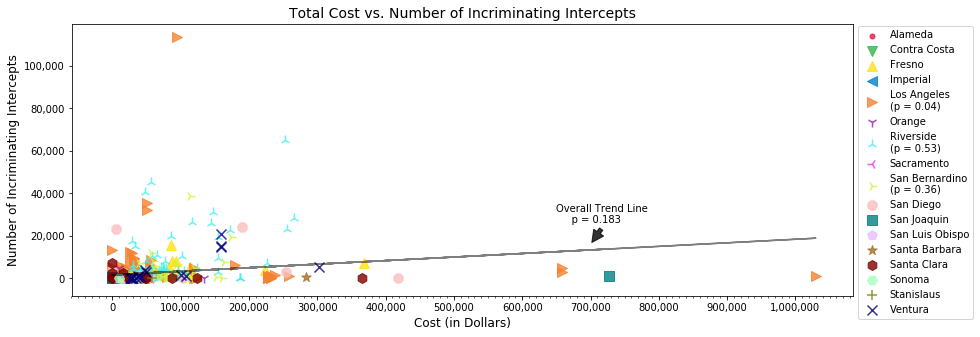

In [18]:
# Plot the incriminating interceptions correlation chart
plt.figure(figsize=(14,5))

for jurisdiction in all_jurisdictions:
    
    jurisdiction_plot_slice = wt_data.loc[lambda df: wt_data['Jurisdiction'] == jurisdiction, :]
    
    if pd.notnull(jurisdiction_data.get_value(jurisdiction,'incriminating_corr')) == True:
        setlabel = jurisdiction + '\n(p = ' + str(round(jurisdiction_data.get_value(jurisdiction,'incriminating_corr'),2)) + ')'
    else:
        setlabel = jurisdiction
    
    plt.scatter(jurisdiction_plot_slice['TotalCost'],
                jurisdiction_plot_slice['Incriminating'], 
                alpha=0.8, 
                marker=jurisdiction_data.get_value(jurisdiction,'shape'),
                color=jurisdiction_data.get_value(jurisdiction,'color'),
                s=100, label=setlabel)

plt.plot(wt_data['TotalCost'],incriminating_p(wt_data['TotalCost']),  alpha=.5, color='black')

plt.title('Total Cost vs. Number of Incriminating Intercepts', fontsize=14)
plt.ylabel('Number of Incriminating Intercepts', fontsize=12)
plt.xlabel('Cost (in Dollars)', fontsize=12)

ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(100000))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10000))

ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

trend_annotation = 'Overall Trend Line \n     p = ' + str(cost_incriminating_r)
ax.annotate(trend_annotation, xy=(700000,16000), xytext=(650000,26000), arrowprops=dict(facecolor='black', alpha=0.8, shrink=0.1))

plt.legend(loc=1, bbox_to_anchor=(1.16,1.01))
plt.show()


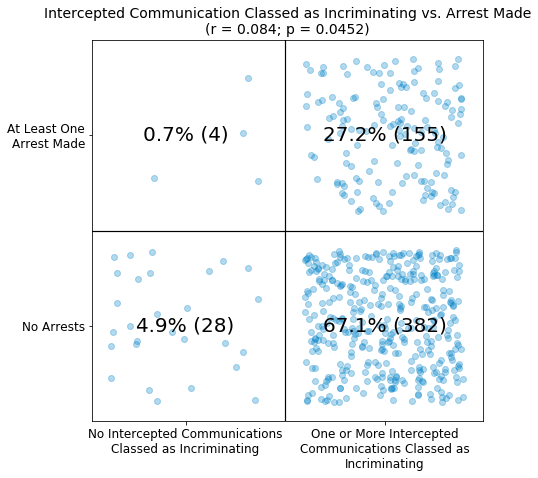

In [60]:

plt.figure(figsize=(7,7))


ax = sns.regplot(x=wt_data['Incriminating_Binary'],
                 y=wt_data['Arrested_Binary'],
                 color='#0082c8',
                 scatter_kws={'alpha':0.3},
                 x_jitter=0.4,
                 y_jitter=0.4,
                 fit_reg=False)

plt.title('Intercepted Communication Classed as Incriminating vs. Arrest Made\n(r = ' + str(incriminating_arrest_r) + '; p = ' +str(incriminating_arrest_p) + ')', fontsize=14)

ax.axvline(0.5, linestyle='-', color='black', lw=1.2)
ax.axhline(0.5, linestyle='-', color='black', lw=1.2)


ax.set_ylabel('')
ax.set_xlabel('')

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_ticklabels(['','No Intercepted Communications\nClassed as Incriminating', 'One or More Intercepted\nCommunications Classed as\nIncriminating'], size=12)

ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_ticklabels(['', 'No Arrests','At Least One\nArrest Made'], size=12)

arrested_true = wt_data.loc[lambda df: wt_data['Arrested_Binary'] == 1, :]
arrested_false = wt_data.loc[lambda df: wt_data['Arrested_Binary'] == 0, :]

total = wt_data.shape[0]

f_f = arrested_false.loc[lambda df: arrested_false['Incriminating_Binary'] == 0, :].shape[0]
plt.text(0,0, str(round(100*f_f/total,1)) + '%'+ ' (' +str(f_f) + ')', va='center', ha='center', size=20)

f_t = arrested_true.loc[lambda df: arrested_true['Incriminating_Binary'] == 0, :].shape[0]
plt.text(0,1, str(round(100*f_t/total,1)) + '%'+ ' (' +str(f_t) + ')', va='center', ha='center', size=20)

t_f = arrested_false.loc[lambda df: arrested_false['Incriminating_Binary'] == 1, :].shape[0]
plt.text(1,0, str(round(100*t_f/total,1)) + '%'+ ' (' +str(t_f) + ')', va='center', ha='center', size=20)

t_t = arrested_true.loc[lambda df: arrested_true['Incriminating_Binary'] == 1, :].shape[0]
plt.text(1,1, str(round(100*t_t/total,1)) + '%'+ ' (' +str(t_t) + ')', va='center', ha='center', size=20)

plt.show()


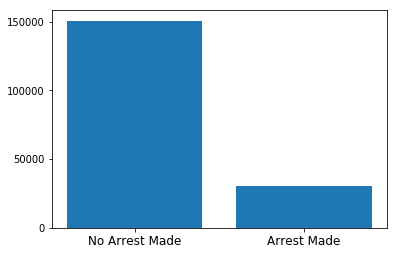

In [64]:
# Surveilled leading to arrest vs. surveilled leading to no arrests (bar chart)

arrested_tf = [1,0]
persons_surv = [wt_data.loc[lambda df: wt_data['Arrested_Binary'] == 1, :]['Persons'].sum(), wt_data.loc[lambda df: wt_data['Arrested_Binary'] == 0, :]['Persons'].sum()]

arrest_surv = pd.DataFrame()
arrest_surv['arrested'] = arrested_tf
arrest_surv['n_surveilled'] = persons_surv

ax = plt.axes()

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_ticklabels(['','No Arrest Made', 'Arrest Made'], size=12)

ax.yaxis.set_major_locator(ticker.MultipleLocator(50000))

plt.bar(arrest_surv['arrested'], arrest_surv['n_surveilled'])

plt.show()

In [ ]:
# Cost and Arrests by crime (Heat Map)

## Bibliography